In [ ]:
# base 
import os 
import sys
from src import helpers, config, plotting, evaluation
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle
import logging
from pathlib import Path
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional, Iterable, Hashable, Type

# base
from sklearn.base import TransformerMixin

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# models
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')


# yet to arrange
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
# test
assert config.TRAIN_FILE_PATH == Path.cwd().parent / "data" / "final"
assert config.REPORTS_PATH == Path.cwd().parent / "reports" / "figures"
assert config.RAW_FILE_PATH == Path.cwd().parent / "data" / "raw"

In [81]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = config.DEFAULT_FIGSIZE
mpl.rcParams['lines.linewidth'] = config.DEFAULT_PLOT_LINEWIDTH
mpl.rcParams['lines.linestyle'] = config.DEFAULT_PLOT_LINESTYLE
mpl.rcParams['font.size'] = config.DEFAULT_AXIS_FONT_SIZE

# logging settings 
# logging.basicConfig(level=logging.DEBUG, format='%(levelname)s:%(message)s')
pd.set_option('display.max_columns', 30)
TARGET = 'status'

DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [39]:
# download and place data in the raw folder
raw_filename = 'Loan_Default.csv'
if os.path.exists(config.RAW_FILE_PATH / raw_filename): 
    print(f'READING FROM THE LOCAL COPY')
    df = pd.read_csv(config.RAW_FILE_PATH / raw_filename)
else: 
    print(f'FILE DOES NOT EXIST: {raw_filename}')
    print('DOWNLOADING DATA >>>')
    df = pd.read_csv('gs://aml_1/Loan_Default.csv')
    df.to_csv(config.RAW_FILE_PATH / raw_filename)
df.head()

READING FROM THE LOCAL COPY


,Unnamed: 0,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [40]:
df.columns = helpers.standardize_cols(df.columns)

### Hypotheses 

1. To drop 
    - unnamed:_0
    - id -> UID
    - year -> No variation 
    - interest_rate_spread -> Not able to discriminate

1. Demographics
    - Gender -> Joint less likely to default -> Change to categorical
        - Engineer whether loan was joint or not??
        - Sex not provided

2. Loan types 
    - loan_type -> what is a type 2 loan? 
    - loan_limit -> missing values -> ncf tends to default more 
    - lump_sum_payment -> remap 
    - approv_in_adv -> NA 908
    - term -> most likely not going to be discriminating
    - interest_only 
3. Purpose 
    - loan_purpose
    - credit_worthiness
    - open_credit -> imbalanced might not be worth to compute
    - business_or_commercial -> higher chance of default if biz/comm
    - 

4. Deterministic 
    - construction_type
    

-dtir1 -- debt to income ratio 

loan_limit                    3344
approv_in_adv                  908
loan_purpose                   134
rate_of_interest             36439
upfront_charges              39642
term                            41
neg_ammortization              121
interest_only                    0
property_value               15098
occupancy_type                   0
secured_by                       0

### Interest only
- Approach: map to categorical

What Is an Interest-Only Mortgage? An interest-only mortgage is a type of mortgage in which the mortgagor (the borrower) is required to pay only the interest on the loan for a certain period. The principal is repaid either in a lump sum at a specified date, or in subsequent payments.


In [115]:
df['interest_only'].value_counts()

interest_only_mapping = {'not_int': False, 'int_only': True}  
df['interest_only'] = df['interest_only'].map(interest_only_mapping).astype('category')

In [116]:
# check against target
df.groupby(TARGET)['interest_only'].value_counts(normalize=True)

status       
0       False    0.953870
        True     0.046130
1       False    0.946996
        True     0.053004
Name: interest_only, dtype: float64

In [113]:
# lost train of thought
# df.pivot_table(values=loan, index=TARGET)

""
status
0
1


### Lump sum payment
- Approach: map to categorical

In [98]:
df['lump_sum_payment'].value_counts()

not_lpsm    145286
lpsm          3384
Name: lump_sum_payment, dtype: int64

In [106]:
lump_sum_mapping = {'not_lpsm': False, 'lpsm': True}  
df['lump_sum_payment'] = df['lump_sum_payment'].map(lump_sum_mapping).astype('category')

In [109]:
df.groupby('status')['lump_sum_payment'].value_counts(normalize=True)

status       
0       False    0.993252
        True     0.006748
1       False    0.928273
        True     0.071727
Name: lump_sum_payment, dtype: float64

DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved


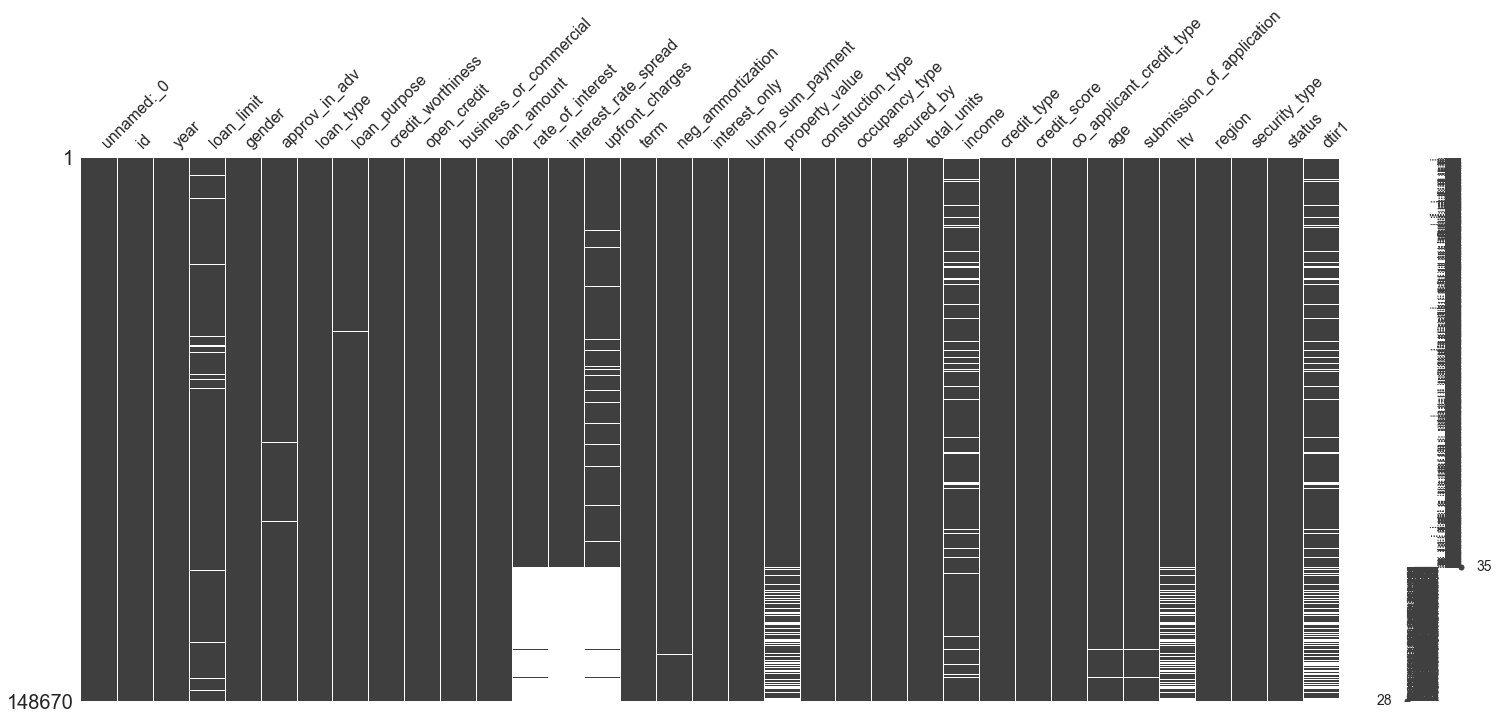

In [41]:
msno.matrix(df.sort_values(by=TARGET))
plt.savefig(config.REPORTS_PATH / 'target_related_missing.png', dpi=300, bbox_inches='tight')

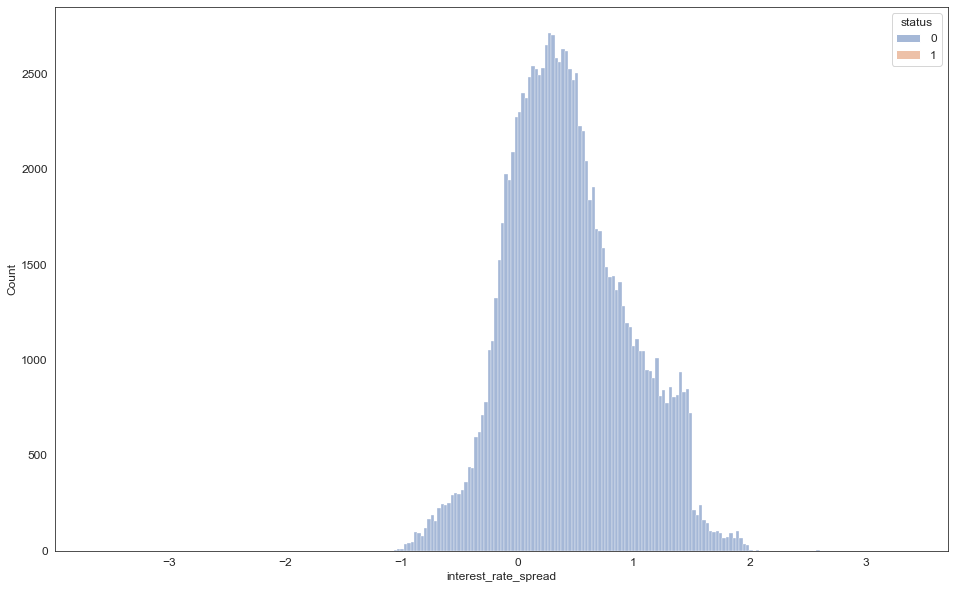

In [42]:
sns.histplot(data=df, x='interest_rate_spread', hue=TARGET)
plt.show()

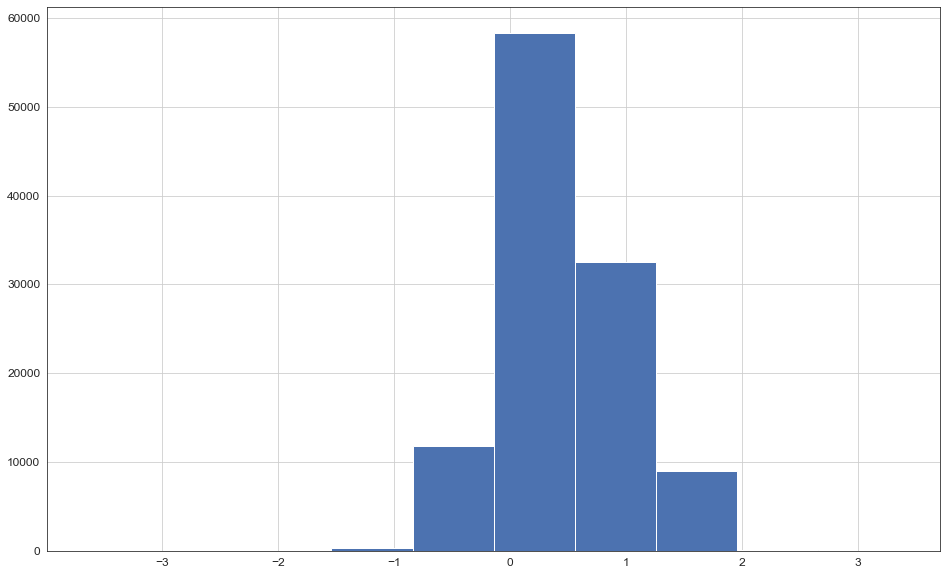

In [43]:
df.interest_rate_spread.hist()
plt.show()

In [44]:
df = df.drop(columns=['unnamed:_0', 'id', 'year', 'interest_rate_spread'])

Gender

In [50]:
df['gender'].nunique()
df['gender'].value_counts()

df['gender'] = helpers.convert_to_dtype(df['gender'], type='categorical')

Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: gender, dtype: int64

In [51]:
df['joint_loan'] = df['gender'].apply(lambda x: x == 'Joint')

DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe4174a0d90>
DEBUG:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe4174a0d90> on colorbar
DEBUG:Setting pcolormesh
DEBUG:top of axes not in the figure, so title not moved


<AxesSubplot:>

DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved


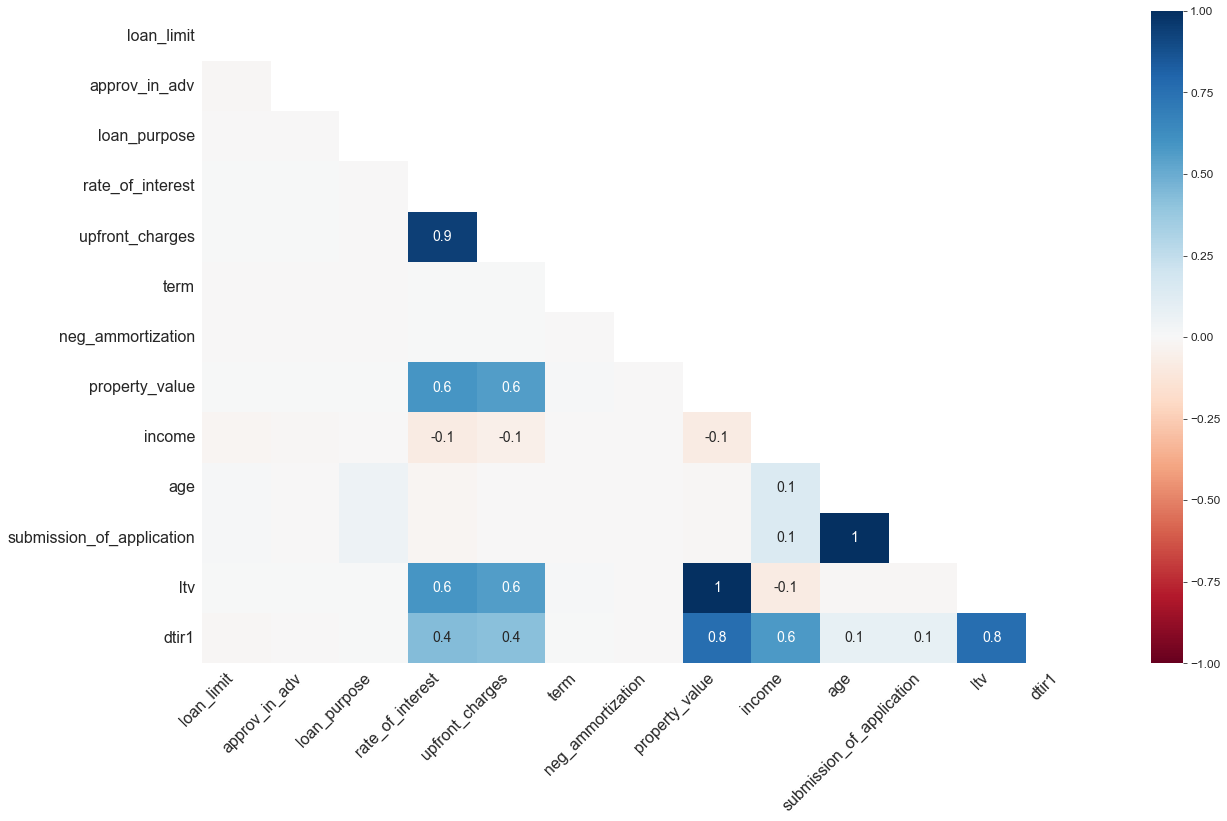

In [57]:
msno.heatmap(df)

<AxesSubplot:>

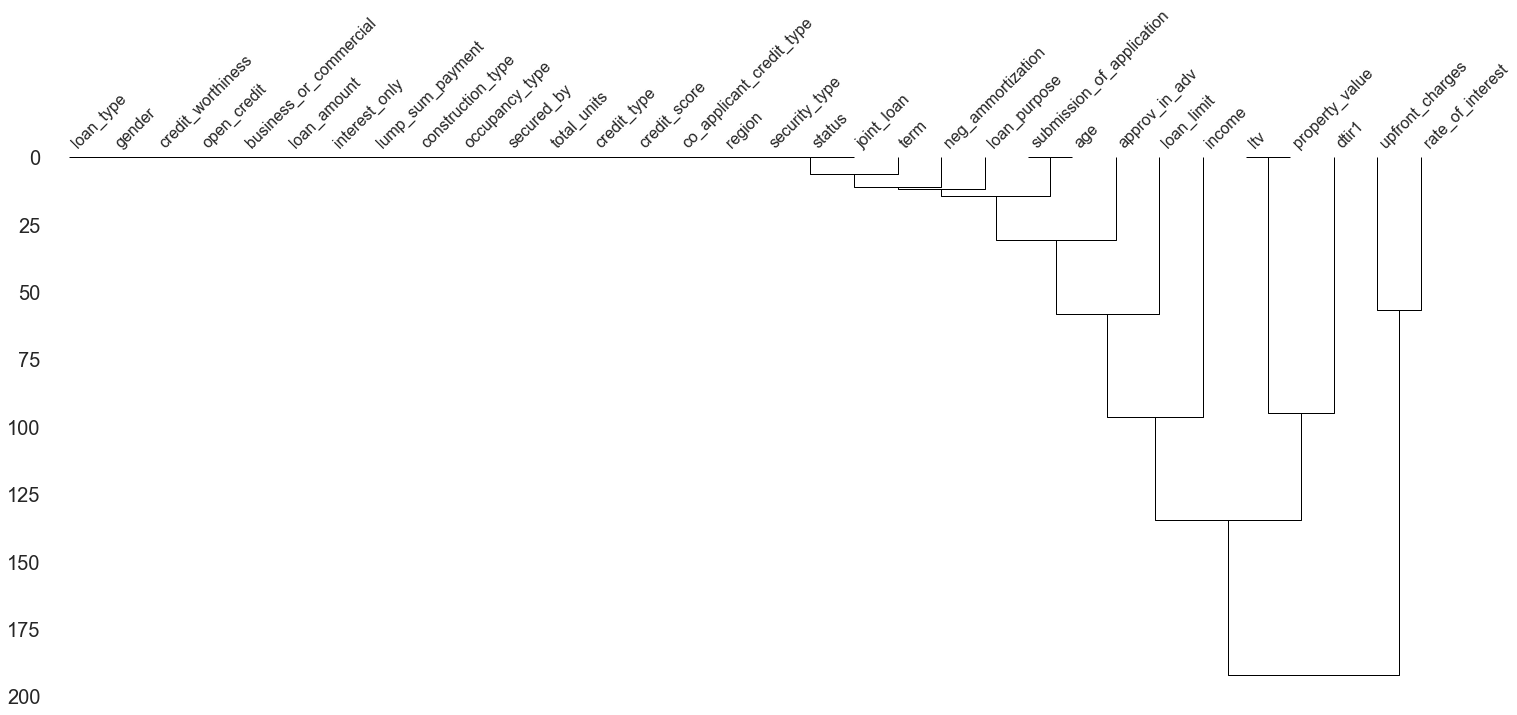

In [59]:
msno.dendrogram(df)

In [77]:
df.shape[0]

148670

In [80]:
df['loan_limit'].isna().sum()

3344

In [65]:
missing_loan_limits = df.loc[df['approv_in_adv'].isna()]
non_missing_loan_limits = df.loc[~df['approv_in_adv'].isna()]

In [69]:
missing_loan_limits = missing_loan_limits.drop(columns='approv_in_adv')

DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title no

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title no

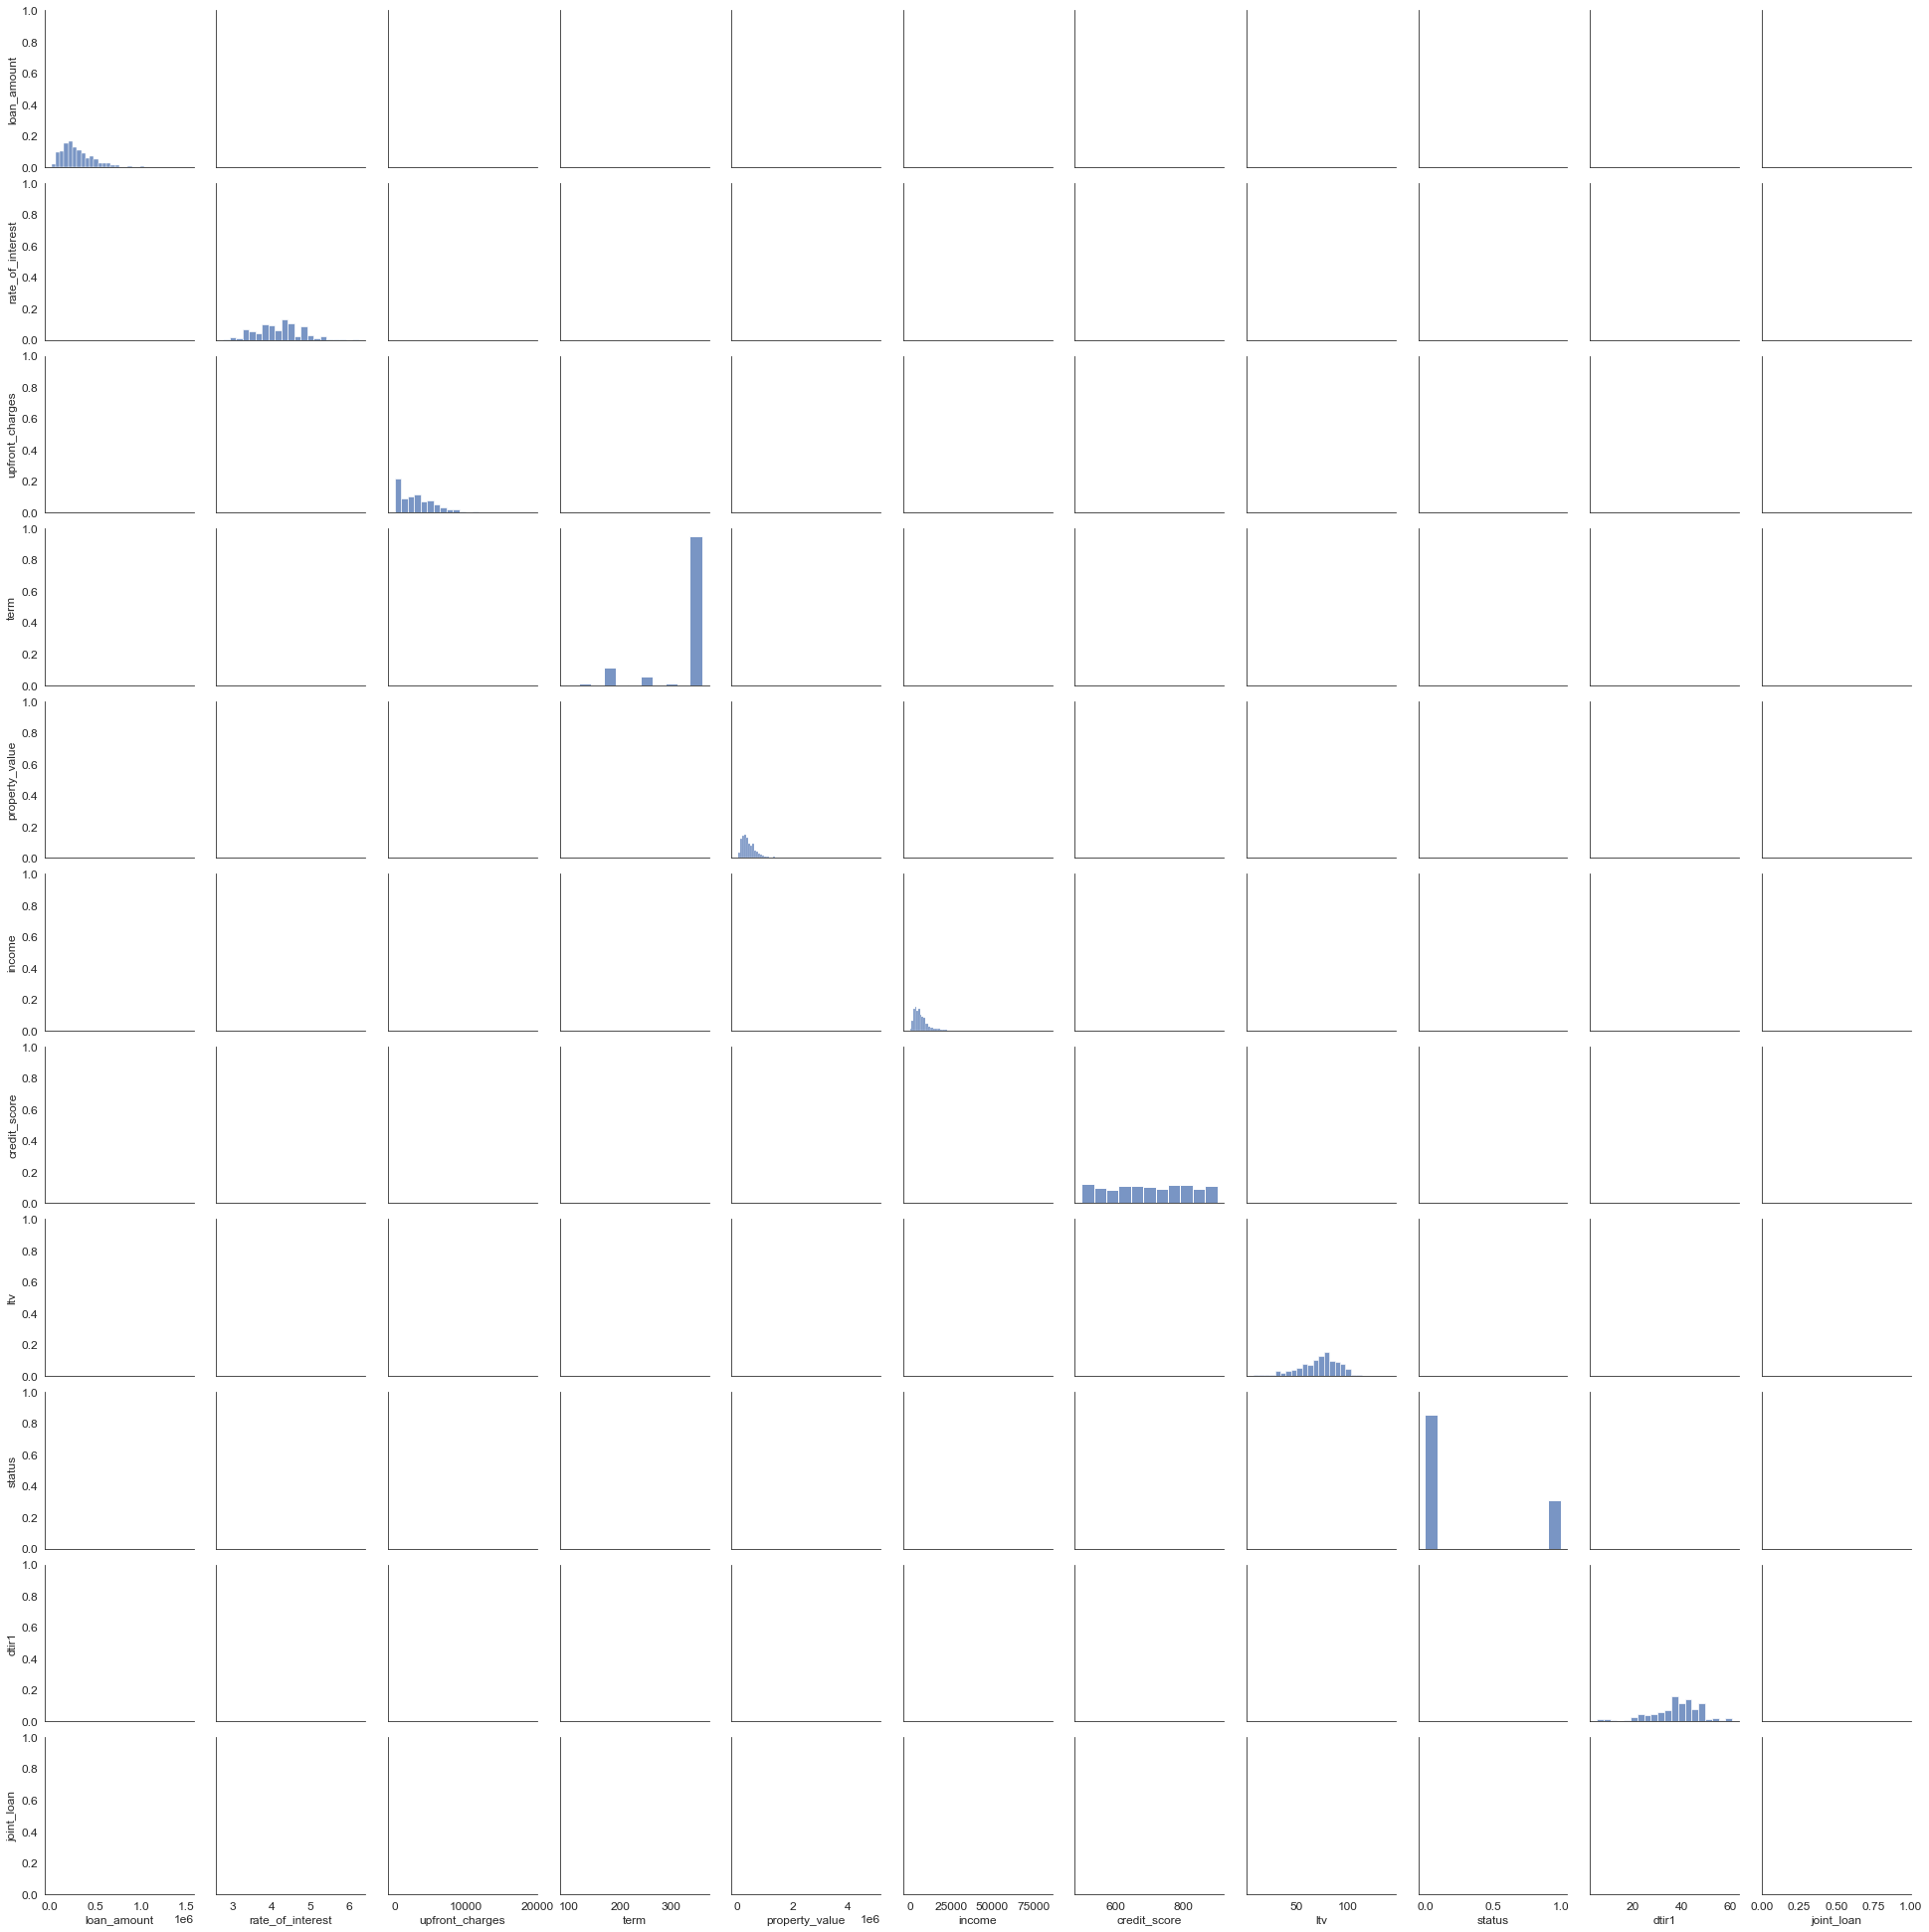

In [70]:
sns.pairplot(missing_loan_limits)

In [67]:
display(missing_loan_limits.describe().T)
display(non_missing_loan_limits.describe().T)

,count,mean,std,min,25%,50%,75%,max
loan_amount,908.0,306720.264317,182481.836547,16500.000000,176500.000000,266500.000000,406500.000000,1.506500e+06
rate_of_interest,667.0,4.166169,0.578084,2.750000,3.750000,4.180000,4.500000,6.240000e+00
upfront_charges,650.0,3317.349985,3177.527534,0.000000,817.455000,2849.115000,4861.875000,1.906363e+04
term,908.0,331.691630,63.168329,96.000000,360.000000,360.000000,360.000000,3.600000e+02
property_value,811.0,464596.794081,357007.118841,48000.000000,248000.000000,388000.000000,588000.000000,4.918000e+06
income,877.0,6806.134550,5722.939281,0.000000,3480.000000,5640.000000,8400.000000,8.238000e+04
credit_score,908.0,701.800661,116.041352,501.000000,602.750000,702.500000,803.000000,9.000000e+02
ltv,811.0,71.616563,19.212385,7.862367,60.054591,74.441341,85.472973,1.405963e+02
status,908.0,0.265419,0.441799,0.000000,0.000000,0.000000,1.000000,1.000000e+00
dtir1,780.0,37.825641,10.255672,5.000000,32.000000,39.000000,45.000000,6.100000e+01


,count,mean,std,min,25%,50%,75%,max
loan_amount,147762.0,331267.666924,183908.655096,16500.000000,196500.00000,296500.00000,436500.000000,3576500.00
rate_of_interest,111564.0,4.044754,0.561215,0.000000,3.62500,3.99000,4.375000,8.00
upfront_charges,108378.0,3224.442232,3251.564283,0.000000,579.40250,2594.85500,4812.500000,60000.00
term,147721.0,335.157757,58.378233,96.000000,360.00000,360.00000,360.000000,360.00
property_value,132761.0,498096.865796,359944.998417,8000.000000,268000.00000,418000.00000,628000.000000,16508000.00
income,138643.0,6958.295334,6501.194155,0.000000,3720.00000,5760.00000,8520.000000,578580.00
credit_score,147762.0,699.776742,115.875124,500.000000,599.00000,699.00000,800.000000,900.00
ltv,132761.0,72.753360,40.061298,0.967478,60.47486,75.13587,86.184211,7831.25
status,147762.0,0.246329,0.430874,0.000000,0.00000,0.00000,0.000000,1.00
dtir1,123769.0,37.732348,10.547274,5.000000,31.00000,39.00000,45.000000,61.00


DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title no

TypeError: No loop matching the specified signature and casting was found for ufunc add

DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title not moved
DEBUG:top of axes not in the figure, so title no

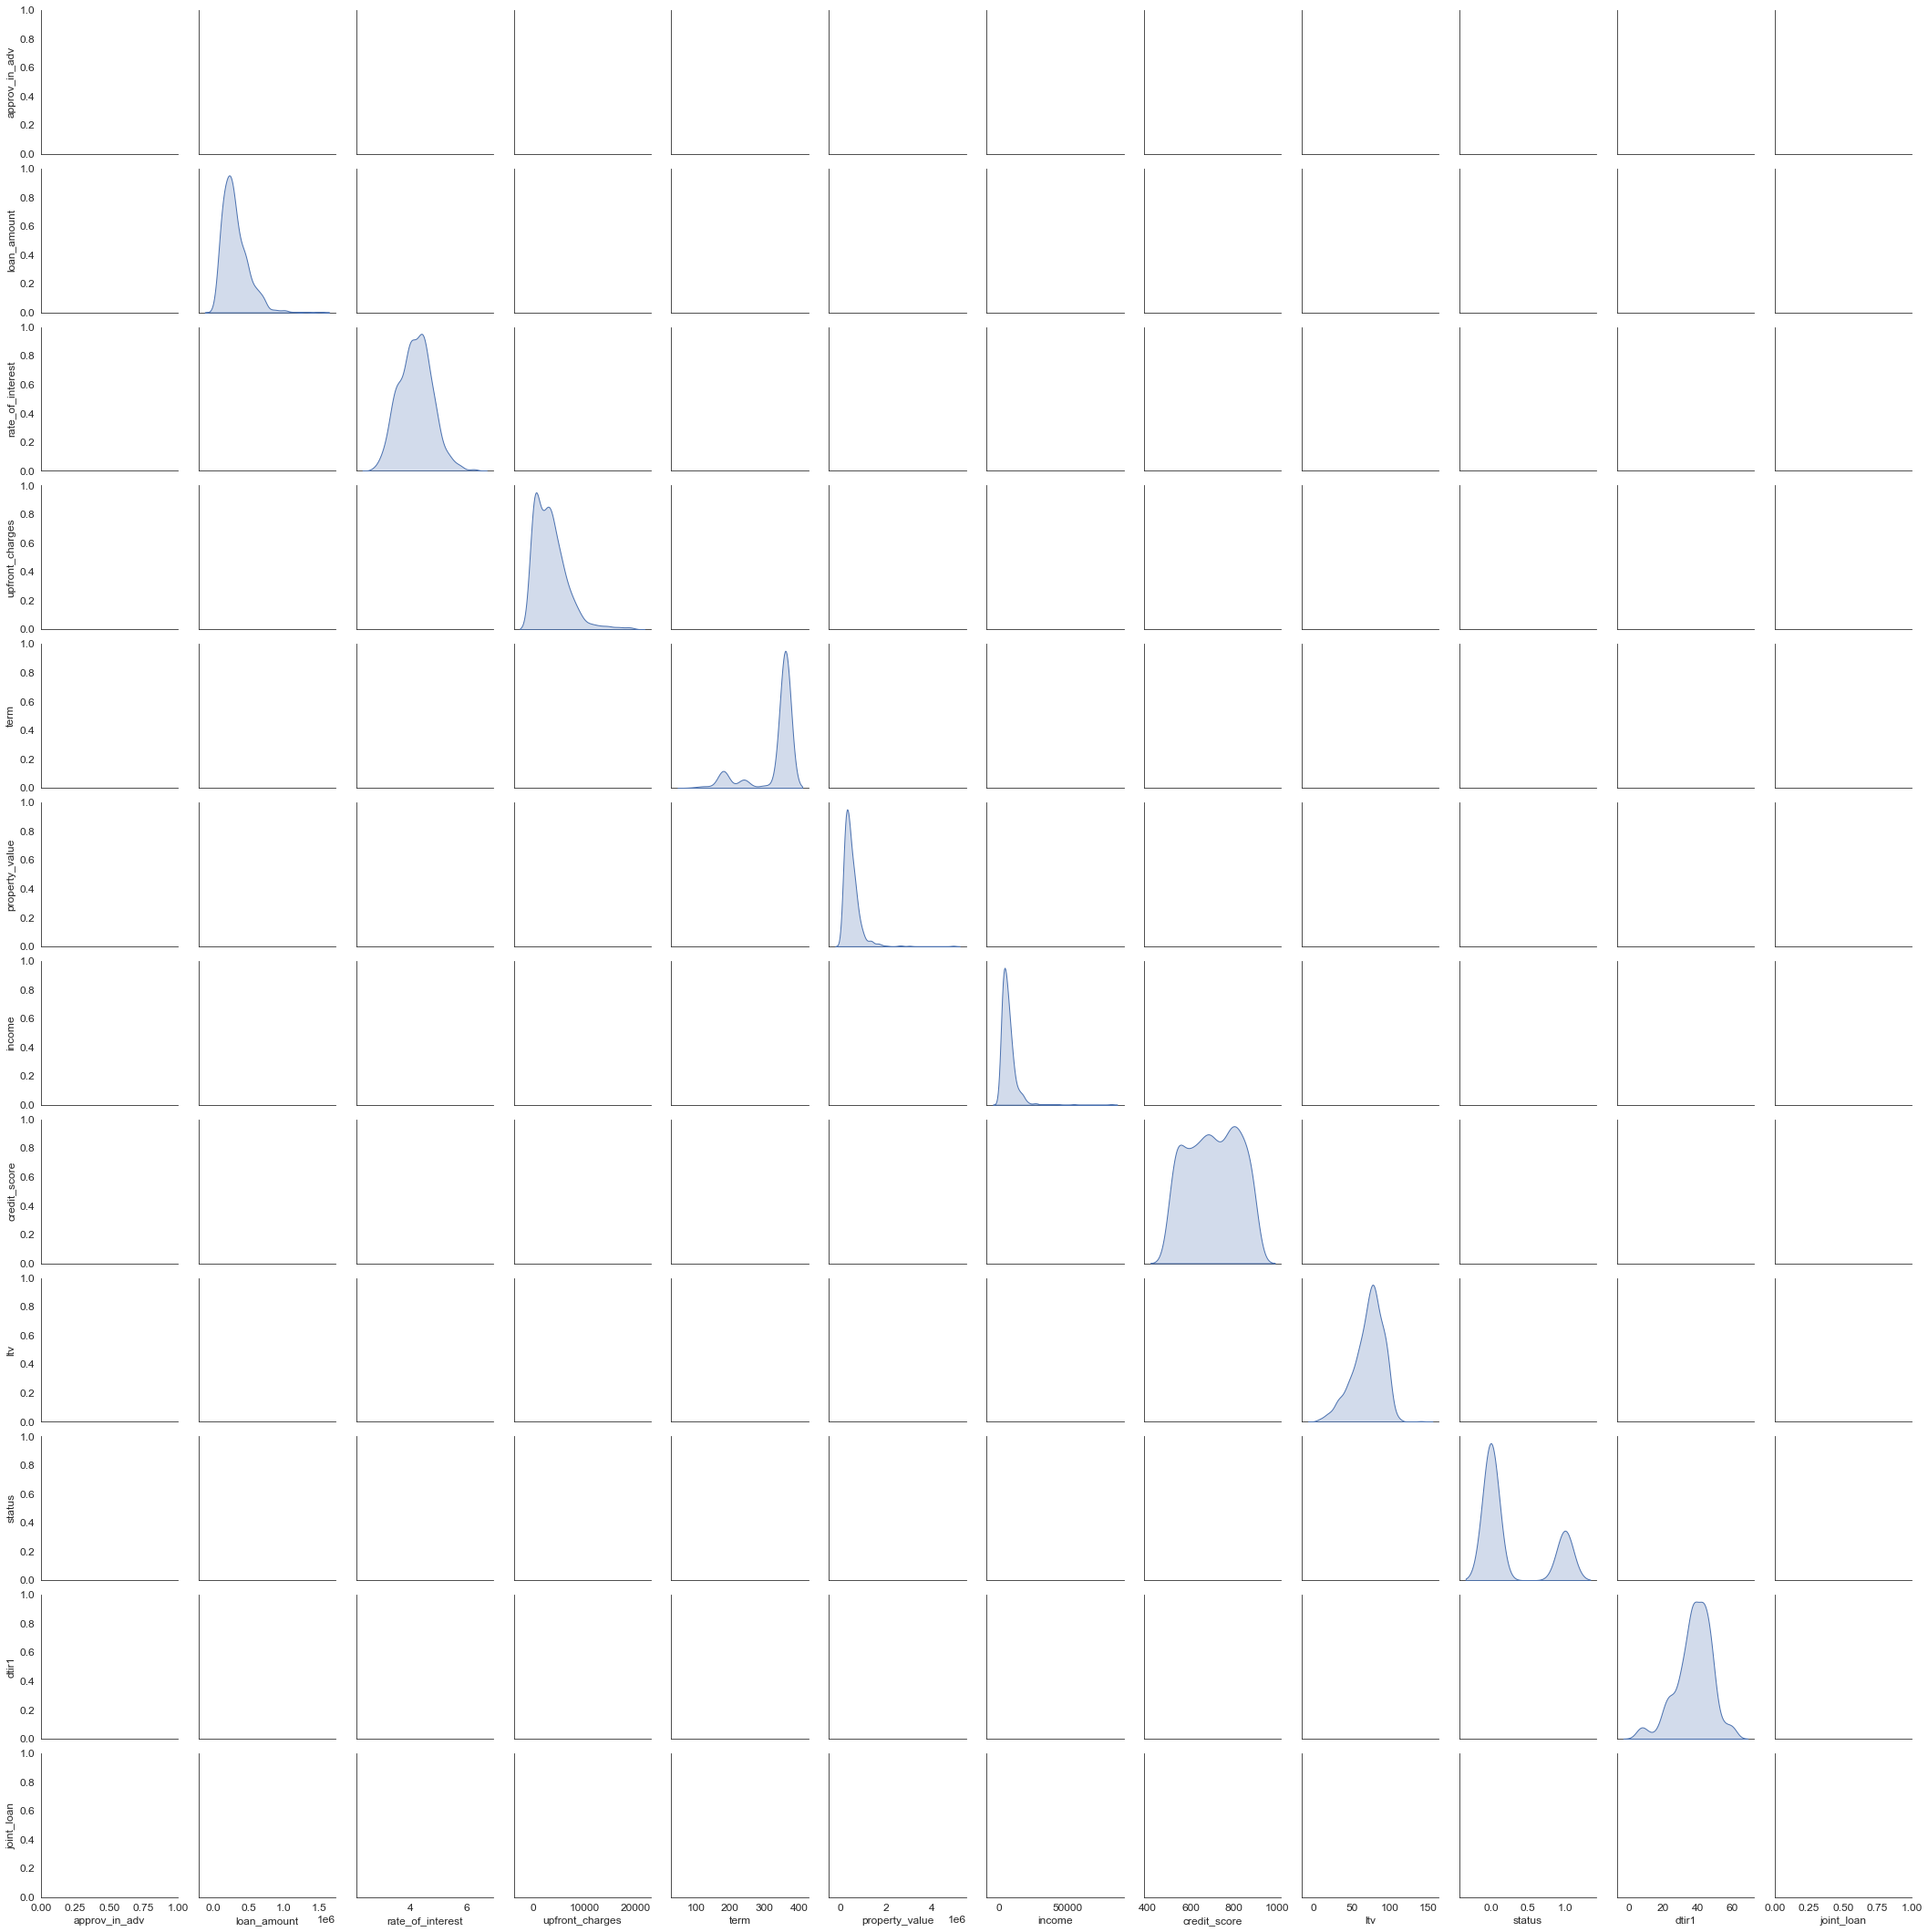

In [63]:
plotting.quick_plot(missing_loan_limits)